# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,root_mean_squared_error
import itertools
import warnings
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device("CUDA" if torch.backends.mps.is_available() else "cpu")

## Below piece of code is to ignore the warnings

In [2]:
warnings.filterwarnings('ignore')

## Downloading the CEAT limited historical stock data using yfinance from 2020-01-01 to 2025-12-18

In [3]:
df=yf.download(
    "CEATLTD.NS",
    start='2008-01-01',
    end='2025-12-28'
)


[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,CEATLTD.NS,CEATLTD.NS,CEATLTD.NS,CEATLTD.NS,CEATLTD.NS
Date,,,,,
2008-02-01,137.972290,198.954518,137.972290,198.954518,213242
2008-02-04,146.357361,151.693306,119.334611,119.334611,185908
2008-02-05,146.547913,150.168732,140.259121,146.357343,115340
2008-02-06,142.202911,146.357323,141.021379,141.021379,33737
2008-02-07,133.932220,146.090550,130.730656,138.734573,115873


## I am going to predict the Close values for 20% of this dataset.But before that data cleaning and processing must be done.
## Retriving the close feature from df dataset and check for any missing values on a daily basis and fill the missing values with ffill() method.

In [5]:
df_close=df['Close']
df_close

Ticker,CEATLTD.NS
Date,
2008-02-01,137.972290
2008-02-04,146.357361
2008-02-05,146.547913
2008-02-06,142.202911
2008-02-07,133.932220
...,...
2025-12-22,3932.800049
2025-12-23,3903.199951
2025-12-24,3878.000000


In [6]:
df_close=df_close.asfreq('B')  ## "B" is business days because stock market doesnt run on holidays and weekends

In [7]:
df_close.isna().any()

,0
Ticker,
CEATLTD.NS,True


In [8]:
df_close=df_close.ffill()  ## ffill() method replaces NaN values with previous day values.

In [9]:
df_close.isna().any()

,0
Ticker,
CEATLTD.NS,False


In [10]:
df_close

Ticker,CEATLTD.NS
Date,
2008-02-01,137.972290
2008-02-04,146.357361
2008-02-05,146.547913
2008-02-06,142.202911
2008-02-07,133.932220
...,...
2025-12-22,3932.800049
2025-12-23,3903.199951
2025-12-24,3878.000000


## Splitting the dataset into train(80%) and test(20%) dataset

In [107]:
train_end=(int)(80*len(df_close)/100)
df_close_train=df_close[0:train_end]
df_close_test=df_close[train_end:]

# Fitting the model for train dataset

## checking for stationarity using plots and adfuller test .

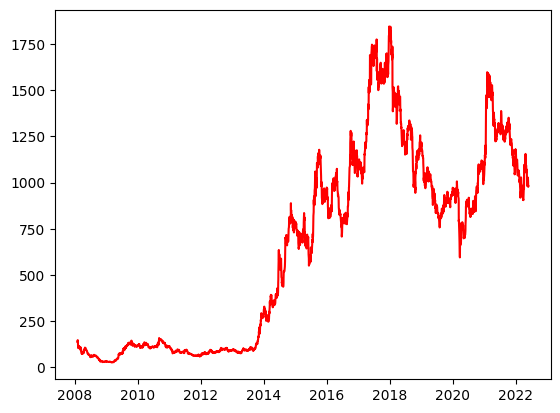

In [108]:
plt.plot(df_close_train,color='red')
plt.show()

#### On the above plot of df_close_train , we can see that this time seies has variable mean and its variance is not constant over time,implying that this series is not stationary.

## For more solid test, we are going to do adfuller test , in which if its p-value is less than 0.05 we can reject the null hypothesis that is 'the tine series has unit roots i.e, not stationary.'.

In [109]:
adf_result=adfuller(df_close_train)
print(f"The p-value of the adf test is {adf_result[1]}")

The p-value of the adf test is 0.5965569297272428


### From above p-statistic of adf test we can say that the df_close_train series is not stationary.

## So we are going to defferencing method i.e, a(t)=a(t)-a(t-1)

In [110]:
df_close_train_diff = np.diff(df_close_train, axis=0)  ## Use np.diff for NumPy arrays

## Performing stationary test on differentiated series by visually and using adf test

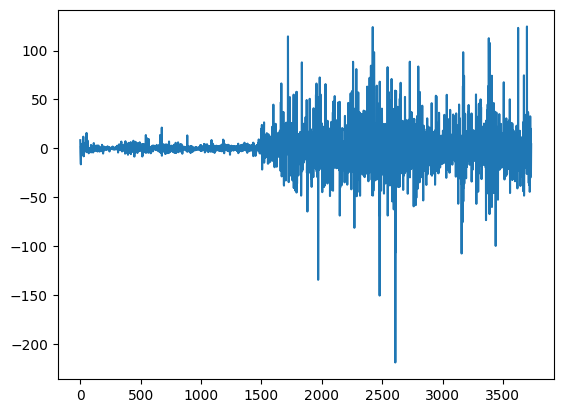

In [111]:
plt.plot(df_close_train_diff)
plt.show()

In [112]:
adf_result_diff=adfuller(df_close_train_diff)
print(f"The p-value of the adf test on differentiated series is {adf_result_diff[1]}")

The p-value of the adf test on differentiated series is 8.137171946192285e-26


### Since the p-value is less than 0.05 , the differentiated series is stationary. So the value of d in ARIMA(p,d,q) is 1.

## Now finding the value of p and q from pacf and acf plots of differentiated series respectively and using grid search method to verify our choices of (p,d,q) or find any other optimal parameters.

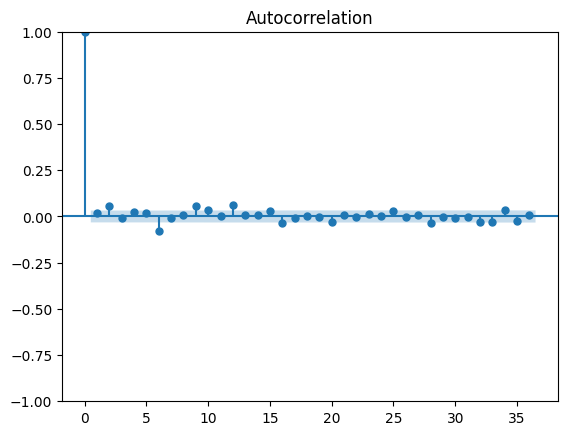

In [113]:
plot_acf(df_close_train_diff)
plt.show()

### By analysing the acf plots , there is a significance correlation in lag 4,and lag 6 and after that almost every lag was within noise band.

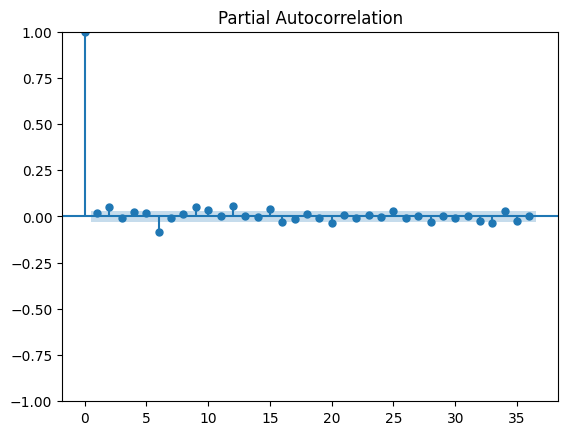

In [114]:
plot_pacf(df_close_train_diff)
plt.show()

### By analysing the above pacf plot, there is a significance correlation in lag 4,6 and after that almost every lag was within noise band

## By analysing the acf and pacf plots the optimal (p,d,q) is (4,1,4) , but acf and pacf plots may be misleading, so we are going to gird search method to get the optimal triplet.

### The main point of grid search method is,we are going to make every possible triplets using the range of p,d,q and we will pass each triplets as a parameter to arima model. The model with least 'AIC' score is the model with optimal paramters.

In [115]:
p=range(0,7) #from the plot lag 6 is the last lag which is significant.
d=range(1,2) # from adf test we know d=1 makes the series stationary
q=range(0,7) #from the plot lag 6 is the last lag which is significant.

pdq=list(itertools.product(p,d,q)) # this will make all possible triplets from range of p,d,q.

best_aic=np.inf
best_order=None
best_model=None

for order in pdq:
    try:
        model=ARIMA(df_close_train,order=order)
        model_fit=model.fit()
        if model_fit.aic<best_aic:
            best_aic=model_fit.aic
            best_order=order
            best_model=model_fit
    except:
        continue

In [116]:
print(f"The best model whose optimal parameters are : {best_order}")

The best model whose optimal parameters are : (6, 1, 6)


### So,why there is a difference between the parameters from plots and grid search,one possible answer is that acf plot tells all correlation both direct and indirect between lags,which tells us the q parameter.
### On the other hand, pacf plots tells us only the direct correlation, which gives p.
### The main point is we look for individual effects for AR and MA model in plots , but not their combined results. One possibility is that our parameter from plot may cause overfitting or increase the complexity of the model. So it is rejected in grid search.

# Prediction:

In [117]:
model_predict=best_model.predict(start=df_close_test.index[0],end=df_close_test.index[-1])
model_predict.shape,df_close_test.shape

((935,), (935, 1))

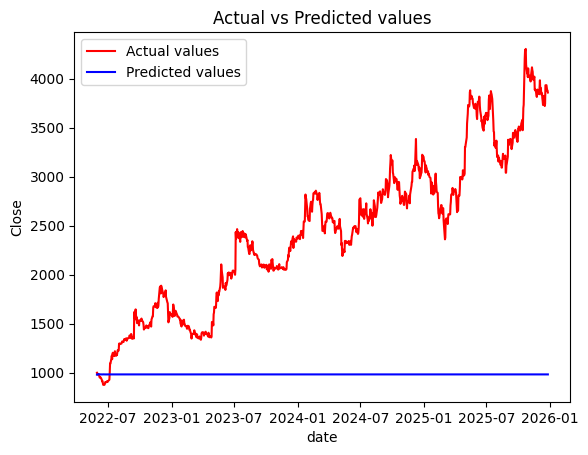

In [118]:
plt.plot(df_close_test,color='red',label='Actual values')
plt.plot(model_predict,color='blue',label='Predicted values')
plt.legend()
plt.title("Actual vs Predicted values")
plt.xlabel('date')
plt.ylabel('Close')
plt.show()

### Why there is a flat line in the predicted values plot , it is the most important problem in time series analysis we are doing extrapolation which include some error and if we predict the next day's value it will inculde the error of the previous and its own error and ultimately the prediction will lead to straight line.

### To overcome this we are going to a method walk-forward validation strategy which assumes that to predict the value of today we know the value of previous day.

### But due to large number of data , it takes hours to implement the walk forward strategy , which is not a instrudy - standard process.

## Metrics for normal predictions:

In [119]:
print(f"The Mean Absolute Error is {mean_absolute_error(df_close_test,model_predict)}")
print(f"The Mean Squared Error is {mean_squared_error(df_close_test,model_predict)}")
print(f"The Root Mean Squared Error is {root_mean_squared_error(df_close_test,model_predict)}")

The Mean Absolute Error is 1460.3231806687613
The Mean Squared Error is 2763416.771216789
The Root Mean Squared Error is 1662.3527818176228


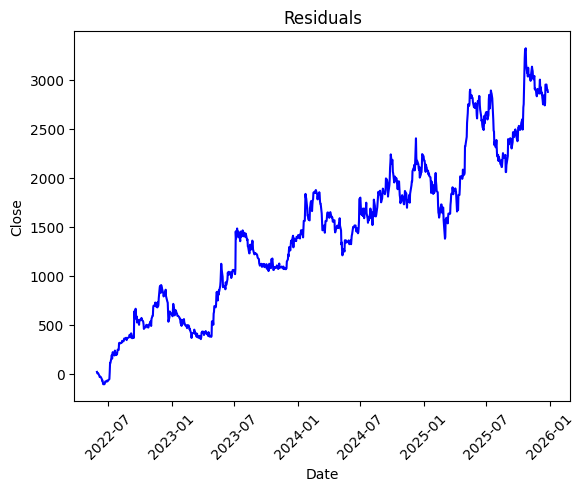

In [120]:
residuals = df_close_test.squeeze() - model_predict
plt.plot(residuals,color='blue')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.show()

## From the residual plot , we can say that it has non-zero trend , therefore we can clearly say it is not a good model since it residual is not a white noise

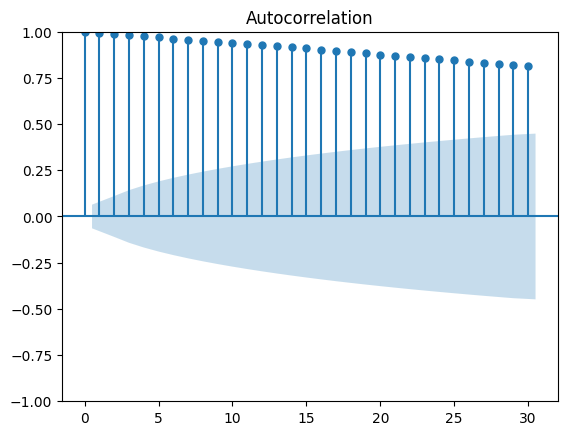

In [121]:
plot_acf(residuals)
plt.show()

## from this plot we can say there is no correlation between any two lags.
## Therefore , our residuals is almost a white noise , which indiactes our model predictions using walk-forward validation is a robust model.

In [122]:
df_close

Ticker,CEATLTD.NS
Date,
2008-02-01,137.972290
2008-02-04,146.357361
2008-02-05,146.547913
2008-02-06,142.202911
2008-02-07,133.932220
...,...
2025-12-22,3932.800049
2025-12-23,3903.199951
2025-12-24,3878.000000


In [123]:
scaler=MinMaxScaler()
df_close_scaled=scaler.fit_transform(df_close.values.reshape(-1,1))

In [124]:
def sliding_window(data,seq_len):
  X=[]
  y=[]
  for i in range(data.shape[0]-seq_len):
    xs=data[i:(i+seq_len),:]
    ys=data[i+seq_len,:]
    X.append(xs)
    y.append(ys)

  return np.array(X),np.array(y)

# ***The Sliding Window method is used to create the sequential data into supervised learning data, which is used for LSTM Neural Network.***:

In [125]:
df_close_scaled

array([[0.0262753 ],
       [0.02823575],
       [0.0282803 ],
       ...,
       [0.90070394],
       [0.90070394],
       [0.89598114]])

In [126]:
seq_len=7
X,y=sliding_window(df_close_scaled,seq_len)

In [127]:
X_train=torch.tensor(X[0:int(0.8*len(X))],dtype=torch.float32)
y_train=torch.tensor(y[0:int(0.8*len(y))],dtype=torch.float32)
X_test=torch.tensor(X[int(0.8*len(X)):],dtype=torch.float32)
y_test=torch.tensor(y[int(0.8*len(y)):],dtype=torch.float32)

# Converting the data (X,y) to be tensor of size(batch_size,seq_len,input_dim) and y to be a tensor of size(batch_size,seq_len,output_dim) and did a split of 80-20% for train and test dataset.

In [128]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([3731, 7, 1]),
 torch.Size([933, 7, 1]),
 torch.Size([3731, 1]),
 torch.Size([933, 1]))

In [129]:
class LSTMModel(nn.Module):

  def __init__(self,input_dim,hidden_dim,layer_dim,output_dim):
    super().__init__()
    self.hidden_dim=hidden_dim # hidden dimension
    self.layer_dim=layer_dim # No of Layers
    self.lstm=nn.LSTM(input_size=input_dim,hidden_size=hidden_dim,num_layers=layer_dim,batch_first=True) # created a lstm model.
    self.fc=nn.Linear(hidden_dim,output_dim) # created a linear layer between then hidden state to output.

  def forward(self,x):
    batch_size=x.size(0)

    h0=torch.zeros(self.layer_dim,batch_size,self.hidden_dim).to(x.device) # h0,c0 and x must be on the same device.
    c0=torch.zeros(self.layer_dim,batch_size,self.hidden_dim).to(x.device)

    out,_=self.lstm(x,(h0,c0))
    out=out[:,-1,:]
    out=self.fc(out)

    return out

# Implemented LSTM class with input_dim=1 , hidden_dim=50 , no of layers = 2 and output_dim=1

In [138]:
model=LSTMModel(input_dim=1,hidden_dim=50,layer_dim=2,output_dim=1)

In [139]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

# Used a mean squared error loss function to compute the loss and Adam optimizer to optimze the weight and bias matrices.

In [140]:
num_epochs=800
losses=[]

for i in range(num_epochs):
  model.train()
  y_train_pred=model(X_train)
  loss=criterion(y_train_pred,y_train)
  losses.append(loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (i+1)%100==0 or i==0 :
    print(f"Epoch : {i+1}   ,   Loss  :  {loss}")

Epoch : 1   ,   Loss  :  0.10456927120685577
Epoch : 100   ,   Loss  :  6.872246012790129e-05
Epoch : 200   ,   Loss  :  6.033834506524727e-05
Epoch : 300   ,   Loss  :  5.44338981853798e-05
Epoch : 400   ,   Loss  :  4.958728459314443e-05
Epoch : 500   ,   Loss  :  4.516907938523218e-05
Epoch : 600   ,   Loss  :  4.0791106584947556e-05
Epoch : 700   ,   Loss  :  3.607257895055227e-05
Epoch : 800   ,   Loss  :  3.917472713510506e-05


# Did a forward propagation with 800 epochs and printed the loss for each 10 epochs.

In [141]:
model.eval()

with torch.no_grad():
  y_test_pred=model(X_test)
  test_loss=criterion(y_test_pred,y_test)

print(test_loss)

tensor(0.0015)


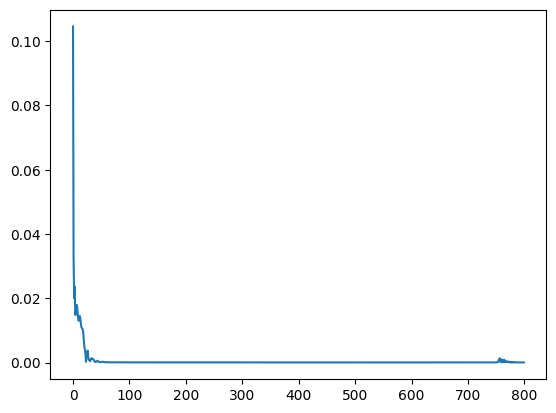

In [142]:
plt.plot(losses)
plt.show()

# From the loss of traning data , we can say see that the loss decreases rapidly in the beginining and began to converge near zero as time goes on and also there is no spikes in the middle which indicates that there is minimal noise and the model is doing good and finally there is no overfiiting.

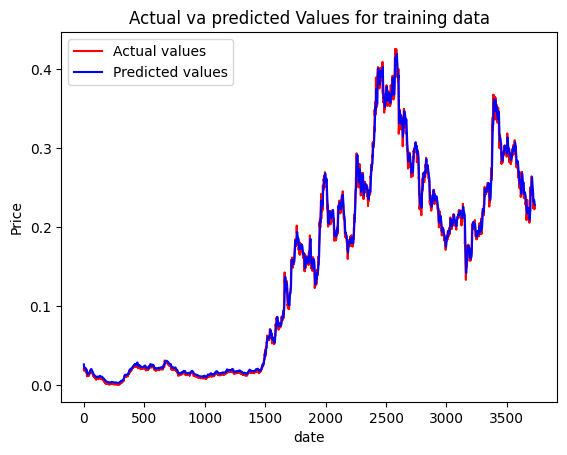

In [143]:
plt.plot(y_train,color='red',label='Actual values')
plt.plot(y_train_pred.detach().numpy(),color='blue',label='Predicted values')
plt.legend()
plt.xlabel('date')
plt.ylabel('Price')
plt.title('Actual va predicted Values for training data')
plt.show()

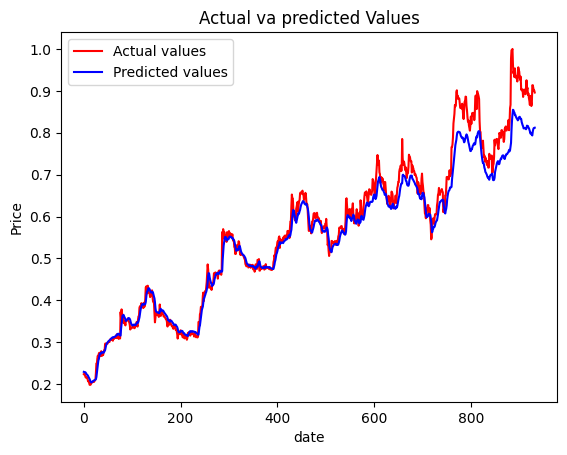

In [144]:
plt.plot(y_test,color='red',label='Actual values')
plt.plot(y_test_pred.detach().numpy(),color='blue',label='Predicted values')
plt.legend()
plt.xlabel('date')
plt.ylabel('Price')
plt.title('Actual va predicted Values')
plt.show()

## Above two graphs are learning curves for training and testing , the first graph shows the prediction values vs original values for training data, which tells us whether the model is learning correctly or not and the second the graph shows the predeicted values vs the actual values for the testing dataset.

# ***ARIMA vs LSTM comparison***

In [145]:
print(f"The Mean Absolute Error for ARIMA is {mean_absolute_error(df_close_test,model_predict)}")
print(f"The Mean Squared Error for ARIMA is {mean_squared_error(df_close_test,model_predict)}")
print(f"The Root Mean Squared Error for ARIMA is {root_mean_squared_error(df_close_test,model_predict)}")

The Mean Absolute Error for ARIMA is 1460.3231806687613
The Mean Squared Error for ARIMA is 2763416.771216789
The Root Mean Squared Error for ARIMA is 1662.3527818176228


In [146]:
print(f"Te mean Absolute Error for LSTM is {mean_absolute_error(y_test,y_test_pred.detach().numpy())}")
print(f"The Mean Squared Error for LSTM is {mean_squared_error(y_test,y_test_pred.detach().numpy())}")
print(f"The Root Mean Squared Error for LSTM is {root_mean_squared_error(y_test,y_test_pred.detach().numpy())}")


Te mean Absolute Error for LSTM is 0.025369560346007347
The Mean Squared Error for LSTM is 0.0014795493334531784
The Root Mean Squared Error for LSTM is 0.03846491128206253


### From the above evaluation for each model both lstm and arima , we can say that lstm performed very well than arima model.

### Compared to ARIMA which results in a flat predicted line , lstm captures both trends and seasonality very well compared to arima.

### If we see computational cost and complexity , lstm is more complex and requires large amount of data than arima model but if we compare with walk forward validation in arima model , lstm is less complex and more efficient than that.

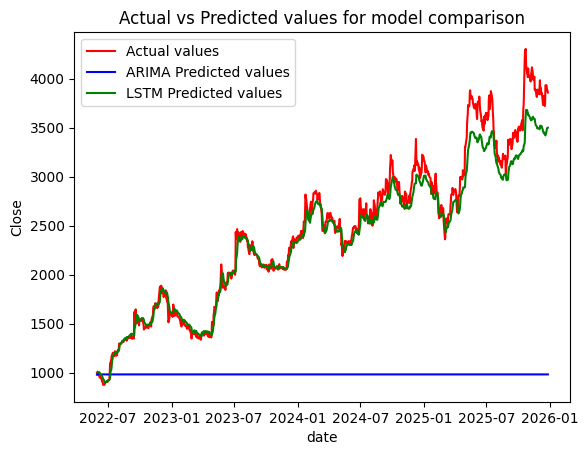

In [157]:
plt.plot(df_close_test.index,df_close_test,color='red',label='Actual values')
plt.plot(df_close_test.index,model_predict,color='blue',label='ARIMA Predicted values')
y_test_pred_np = y_test_pred.detach().cpu().numpy()
y_test_pred_np = y_test_pred_np.reshape(-1, 1)
y_test_pred_original = scaler.inverse_transform(y_test_pred_np)
plt.plot(df_close_test.index[2:],y_test_pred_original,color='green',label='LSTM Predicted values')
plt.legend()
plt.title("Actual vs Predicted values for model comparison")
plt.xlabel('date')
plt.ylabel('Close')
plt.show()